In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import os
%matplotlib inline

In [2]:
sealion_types = ["adult_males", 
    "subadult_males",
    "adult_females",
    "juveniles",
    "pups"]

In [3]:
sealion_sizes_px = {
    "adult_males": 72,
    "subadult_males": 64,
    "adult_females": 56,
    "juveniles": 32,
    "pups": 20
}

In [4]:
sealion_probabilities = {'adult_females': 0.048142699511667254,
 'adult_males': 0.3351506883474506,
 'juveniles': 0.089826648353188876,
 'pups': 0.11096914409391793,
 'subadult_males': 0.41591081969377525}

In [ ]:
def circle()

In [5]:
def gaussian2d(x, y, sx=1, sy=1, x0=0, y0=0, A=1):
    sxx = 2 * sx * sx
    syy = 2 * sy * sy
    xc = x - x0
    yc = y - y0
    xcc = xc * xc
    ycc = yc * yc
    return A * np.exp(-(xcc/sxx + ycc/syy))

In [6]:
def mask_gaussian(size):
    sigma = size / 3.0  # 97% of the gaussian in the size * size square
    half = int((sigma * 5 ) * 2)  # to be sure that the limit of the mask have a value close to 0 (avoid artifact on density map)
    im = np.zeros((2 * half + 1, 2 * half + 1), np.float32)
    for y in range(-half, half + 1):
        for x in range(-half, half + 1):
            im[y + half, x + half] = gaussian2d(x, y, sigma, sigma, 0, 0, 1)
    total_sum = np.sum(im)
    im /= total_sum
    return im

In [7]:
sealion_gaussian = {}
for sealion, size in sealion_sizes_px.items():
    sealion_gaussian[sealion] = mask_gaussian(size)

In [13]:
sealion_gaussian['adult_males'][240-36,240]

8.9704939e-05

In [15]:
sealion_gaussian['subadult_males'][213-32, 213]

0.00011353281

In [21]:
sealion_gaussian['juveniles'][106 - 16, 106]

0.00045413131

In [25]:
sealion_gaussian['adult_females'][186-26,186]

0.00017314499

In [28]:
sealion_gaussian['pups'][66-10,66]

0.001162576

In [8]:
sealion_position_prob = {}
patch_size = 224
for sealion, size in sealion_sizes_px.items():
    kernel_size = patch_size - size
    if kernel_size % 2 == 0:
        kernel_size += 1
    sealion_position_prob[sealion] = np.ones((kernel_size, kernel_size))

In [9]:
def create_density_map(shape, dots, mask, prob=1.0):
    im = np.zeros(shape, np.float32)
    
    # Reweight mask so that the sum is equal to prob
    total_mask_weight = np.sum(mask)
    mask_weighted = (prob/total_mask_weight) * mask 
    
    hmask, wmask = mask.shape
    hmask2 = hmask//2
    wmask2 = wmask//2
    
    for (xf, yf) in dots:
        x = int(round(xf))
        y = int(round(yf))
        xmin = max(0, x - wmask2)
        xmax = min(im.shape[1] - 1, x + wmask2)
        ymin = max(0, y - hmask2)
        ymax = min(im.shape[0] - 1, y + hmask2)
       
        dy_top = y - ymin
        dy_bottom = ymax - y
        dx_left = x - xmin
        dx_right = xmax - x
        im[ymin:ymax+1, xmin:xmax+1] += mask_weighted[hmask2 - dy_top: hmask2 + dy_bottom + 1,\
                                                      wmask2 - dx_left: wmask2 + dx_right + 1] 
    return im

In [10]:
def create_full_density_map(shape, dots):
    n_types = len(sealion_types)
    dmap = np.zeros(shape + (n_types,), np.float32)
    
    for i, sealion in enumerate(sealion_types):
        sdots = [] if sealion not in dots else dots[sealion]
        dmap[:,:,i] = create_density_map(shape, sdots, sealion_gaussian[sealion])
        
    return dmap.astype(np.float32)

In [23]:
def create_sampling_map(shape, dots, sealion_probabilities, background_weight = 2, patch_size=(224, 224)):
    im = np.zeros(shape, np.float32)
    for s, p in sealion_probabilities.items():
        if s in dots:
            im += create_density_map(shape, dots[s], sealion_position_prob[s], p)
            
    # Set the probability of the background.
    # Roughly we try to have background_weight background sample for each sample containing sealions.
    p_sealion = np.sum(im)
    n_empty = np.count_nonzero(im == 0)
    proba_empty = p_sealion/n_empty * background_weight
    im[im==0] = proba_empty
    return im

In [24]:
def split_in_blocks(im_raw, dmap, smap, n_blocks=(4,4), overlap=(448,448)):
    h, w = im_raw.shape[:2]
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    
    if (w + (n_blocks[1] - 1) * overlap[1]) % n_blocks[1] != 0 or \
        (h + (n_blocks[0] - 1) * overlap[0]) % n_blocks[0] != 0:
            print("Warning: check the number of blocks and overlap")
            
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            yield im_raw[y_start:y_end, x_start:x_end,...], dmap[y_start:y_end, x_start:x_end,...], smap[y_start:y_end, x_start:x_end,...]

In [13]:
def generate_training_blocks(root_dir):
    raw_dir = os.path.join(root_dir, "Train")
    dots_dir = os.path.join(root_dir, "TrainDots")
    mask_dir = os.path.join(root_dir, "TrainMask")
    dmap_dir = os.path.join(root_dir, "TrainDensity")
    smap_dir = os.path.join(root_dir, "TrainSampling")
    block_dir = os.path.join(root_dir, "TrainBlock")
    
    os.makedirs(dmap_dir, exist_ok=True)
    os.makedirs(smap_dir, exist_ok=True)
    os.makedirs(block_dir, exist_ok=True)
    
    for filename in os.listdir(raw_dir):
        if not filename.endswith(".jpg"):
            continue
        
        train_id, _ = os.path.splitext(filename)
        # load the raw image, mask and dots
        im_raw = cv2.imread(os.path.join(raw_dir, filename))
        im_mask = cv2.imread(os.path.join(mask_dir, train_id + ".png"), cv2.IMREAD_GRAYSCALE)
        with open(os.path.join(dots_dir, train_id + ".pkl"), "rb") as pfile:
            dots = pickle.load(pfile)
            
        # Create the density map and sampling map
        smap = create_sampling_map(im_raw.shape[:2], dots, sealion_probabilities)
        dmap = create_full_density_map(im_raw.shape[:2], dots)
        
        # Apply mask on all
        im_raw[im_mask==0, ...] = 0
        smap[im_mask==0, ...] = 0
        dmap[im_mask==0, ...] = 0
        
        # Generate blocks and save them
        for i, (braw, bdmap, bsmap) in enumerate(split_in_blocks(im_raw, dmap, smap)):
            cv2.imwrite(os.path.join(block_dir, "{tid}_{bid}.jpg".format(tid=train_id, bid=i)), braw)
            np.savez_compressed(os.path.join(dmap_dir, "{tid}_{bid}.npz".format(tid=train_id, bid=i)), dmap=bdmap)
            np.savez_compressed(os.path.join(smap_dir, "{tid}_{bid}.npz".format(tid=train_id, bid=i)), smap=bsmap)

In [14]:
def show_density(im, density):
    max_density = np.max(density)
    normalized_density = density/max_density
    im_fp32 = im.astype(np.float32)
    im_masked = im_fp32.copy()
    im_masked[:,:,0] = (im_fp32[:,:,0] * normalized_density)
    im_masked[:,:,1] = (im_fp32[:,:,1] * normalized_density)
    im_masked[:,:,2] = (im_fp32[:,:,2] * normalized_density)
    return im_masked.astype(np.uint8), (normalized_density * 255).astype(np.uint8)

In [15]:
with open("../data/sealion/TrainDots/872.pkl", "rb") as ifile:
    dots = pickle.load(ifile)

In [16]:
im_train = cv2.imread("../data/sealion/TrainBlock/872_")

In [17]:
location_prob = create_sampling_map(im_train.shape[:-1], dots, sealion_probabilities)

In [18]:
density_female = create_density_map(im_train.shape[:-1], dots['adult_females'], sealion_gaussian['adult_females'])

In [19]:
im_density, mask_density = show_density(im_train, location_prob)

In [20]:
cv2.imwrite("../data/imk.png", im_density)
cv2.imwrite("../data/kk.png", mask_density)

True

In [21]:
np.sum(density_female)

131.99989

In [25]:
generate_training_blocks("/home/lowik/sealion/data/sealion/")

In [26]:
im = cv2.imread("../data/sealion/TrainBlock/872_6.jpg")

In [27]:
dmap = np.load("../data/sealion/TrainDensity/872_6.npz")["dmap"]

In [28]:
im_density, mask_density = show_density(im, dmap[:,:,2])

In [29]:
cv2.imwrite("../data/dmap.png", im_density)
cv2.imwrite("../data/dmap_mask.png", mask_density)

True

In [35]:
np.sum(dmap[...,2])

115.20237

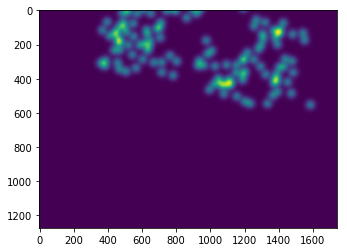

In [34]:
plt.imshow(dmap[...,2])